<a href="https://colab.research.google.com/github/oce-micky/Data-Analytics-Using-IBM_SPSS/blob/main/UDIAI_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import zipfile

# 1. Loading the data
zip_path = '/content/api_data_aadhar_demographic.zip'

data_list = []

# Open zip file
z = zipfile.ZipFile(zip_path)
all_files = z.namelist()
print("Files found:", len(all_files))
for filename in all_files:
    if filename.endswith('.csv'):
        print("Reading:", filename)
        with z.open(filename) as f:
            temp_df = pd.read_csv(f)
            data_list.append(temp_df)

# 2. Merging all file
if len(data_list) > 0:
    master_df = pd.concat(data_list, ignore_index=True)
    print("Merged successfully!")
    print("Total rows:", len(master_df))
    print("Columns:", master_df.columns.tolist())

    # print first 5 rows (simple print, not display)
    print(master_df.head())

else:
    print("No csv files found in zip")

Files found: 6
Reading: api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv
Reading: api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv
Reading: api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv
Reading: api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv
Reading: api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv
Merged successfully!
Total rows: 2071700
Columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']
         date           state    district  pincode  demo_age_5_17  \
0  01-03-2025   Uttar Pradesh   Gorakhpur   273213             49   
1  01-03-2025  Andhra Pradesh    Chittoor   517132             22   
2  01-03-2025         Gujarat      Rajkot   360006             65   
3  01-03-2025  Andhra Pradesh  Srikakulam   532484             24   
4  01-03-2025       Rajasthan     Udaipur   313801             45   

   demo_age_17_  
0          

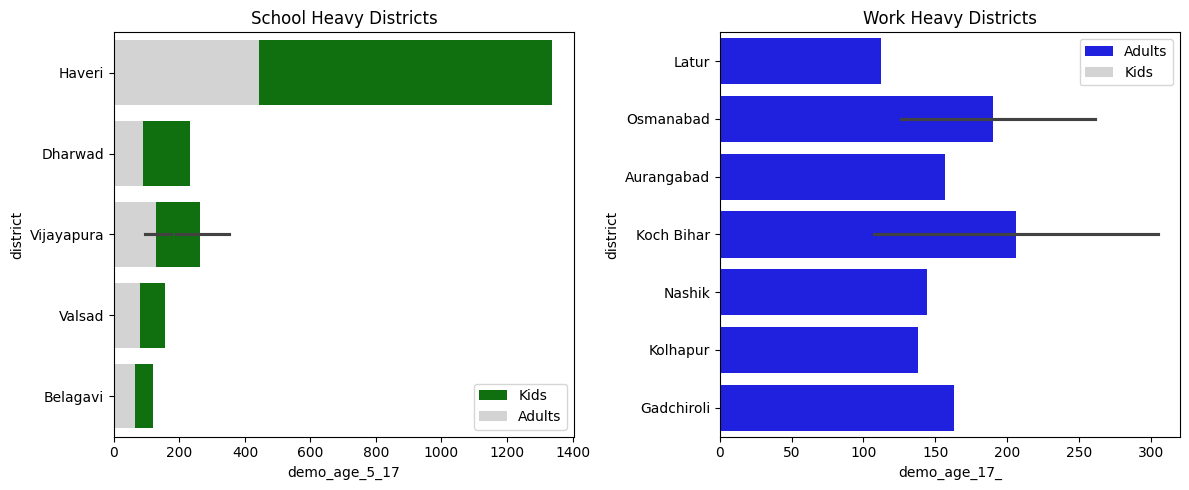

School Districts: ['Haveri', 'Dharwad', 'Vijayapura', 'Valsad', 'Belagavi']
Job Districts: ['Latur', 'Osmanabad', 'Aurangabad', 'Koch Bihar', 'Nashik', 'Kolhapur', 'Gadchiroli']


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# copying df to not change original
df2 = master_df.copy()
# calculating total and ratio
df2['total'] = df2['demo_age_5_17'] + df2['demo_age_17_']
df2['kid_ratio'] = df2['demo_age_5_17'] / (df2['total'] + 0.0001)
# taking only districts with > 100 updates to ignore noise
valid_dist = df2[df2['total'] > 100]
school_top = valid_dist.sort_values('kid_ratio', ascending=False).head(10)
job_top = valid_dist.sort_values('kid_ratio', ascending=True).head(10)

# 3. Plotting
plt.figure(figsize=(12, 5))
# First plot: Schools
plt.subplot(1, 2, 1)
# plotting kids in green
sns.barplot(data=school_top, x='demo_age_5_17', y='district', color='green', label='Kids')
# plotting adults in grey for comparison
sns.barplot(data=school_top, x='demo_age_17_', y='district', color='lightgrey', label='Adults')
plt.title("School Heavy Districts")
plt.legend()
# Second plot: Jobs
plt.subplot(1, 2, 2)
# plotting adults in blue
sns.barplot(data=job_top, x='demo_age_17_', y='district', color='blue', label='Adults')
# plotting kids in grey
sns.barplot(data=job_top, x='demo_age_5_17', y='district', color='lightgrey', label='Kids')
plt.title("Work Heavy Districts")
plt.legend()

plt.tight_layout()
plt.show()
print("School Districts:", school_top['district'].unique().tolist())
print("Job Districts:", job_top['district'].unique().tolist())

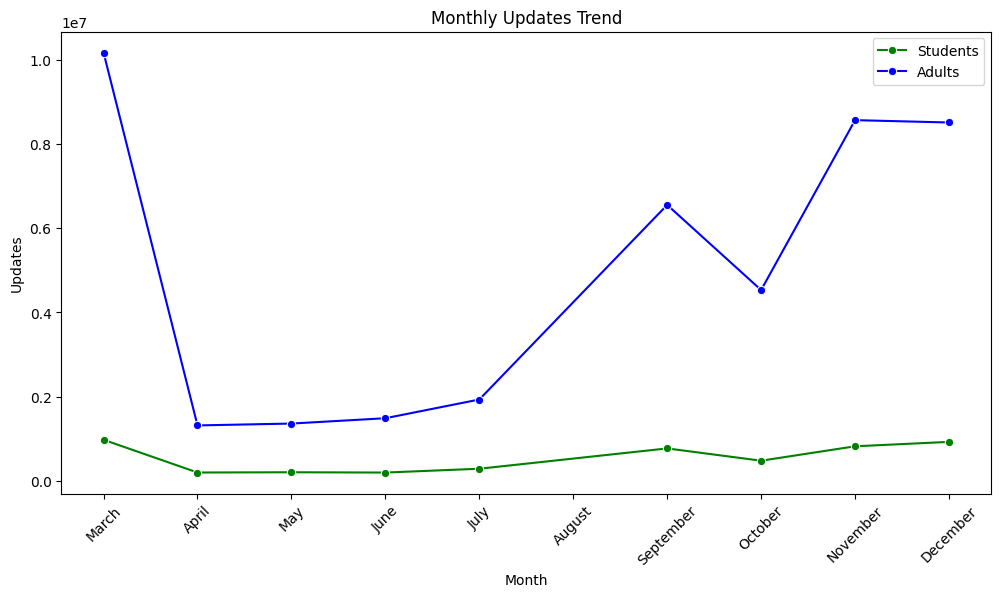

Peak Month Students: March
Peak Month Adults: March


In [10]:

# converting date column to datetime objects
master_df['date'] = pd.to_datetime(master_df['date'], format='%d-%m-%Y', errors='coerce')

master_df['month'] = master_df['date'].dt.month_name()

# grouping by month to see trends
month_data = master_df.groupby('month')[['demo_age_5_17', 'demo_age_17_']].sum()

# reordering months manually
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
month_data = month_data.reindex(months_order)

plt.figure(figsize=(12, 6))

sns.lineplot(data=month_data, x=month_data.index, y='demo_age_5_17', marker='o', label='Students', color='green')

sns.lineplot(data=month_data, x=month_data.index, y='demo_age_17_', marker='o', label='Adults', color='blue')

plt.title("Monthly Updates Trend")
plt.xlabel("Month")
plt.ylabel("Updates")
plt.xticks(rotation=45)
plt.legend()
plt.show()

print("Peak Month Students:", month_data['demo_age_5_17'].idxmax())
print("Peak Month Adults:", month_data['demo_age_17_'].idxmax())

In [11]:
# grouping by state and district to get totals
dist_sum = master_df.groupby(['state', 'district'])[['demo_age_5_17', 'demo_age_17_']].sum().reset_index()
dist_sum['total'] = dist_sum['demo_age_5_17'] + dist_sum['demo_age_17_']

# finding state average
state_avg = dist_sum.groupby('state')['total'].mean().reset_index()
state_avg.columns = ['state', 'state_mean']

# merging data to compare district vs state average
merged = pd.merge(dist_sum, state_avg, on='state')

# calculating surge (how much bigger than average)
merged['surge_ratio'] = merged['total'] / merged['state_mean']

# filtering outliers (more than 3 times the average)
anomalies = merged[merged['surge_ratio'] > 3].sort_values('surge_ratio', ascending=False)

print("Top Anomalies (Suspicious Districts):")
print(anomalies[['state', 'district', 'total', 'surge_ratio']].head(10))

# Saving all results to csv
print("\nSaving files...")
school_top.to_csv('school_hubs.csv', index=False)
job_top.to_csv('job_hubs.csv', index=False)
month_data.to_csv('seasonality.csv')
anomalies.to_csv('anomalies.csv', index=False)

print("Files saved successfully.")

Top Anomalies (Suspicious Districts):
                state           district   total  surge_ratio
390         Karnataka          Bengaluru  303924     9.680907
265           Gujarat              Surat  357582     7.644297
314   Jammu & Kashmir              Jammu     193     6.342723
1056      West Bengal  South 24 Parganas  401137     6.112095
673            Orissa           Balangir    4790     5.996245
234           Gujarat          Ahmedabad  267884     5.726756
1041      West Bengal        Murshidabad  371953     5.667421
847         Telangana          Hyderabad  216457     5.444931
683            Orissa             Ganjam    4254     5.325266
693            Orissa            Khordha    4048     5.067390

Saving files...
Files saved successfully.
